# Import thư viện

In [1]:
%%capture
!pip install librosa            # for augmentation
!pip install jiwer              # for calculate wer
!pip install tensorflow-io
!pip install sentencepiece      # for subword
!pip install tensorflow-text==2.8.2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from jiwer import wer
# import audiomentations as aud
import sentencepiece as spm
import tensorflow_text as tftext

from IPython import display

In [4]:
print(tf.__version__)
print(tftext.__version__)

2.8.2
2.8.2


# Create dataframe

In [5]:
id2label = {
    '0' : 'xoay ghế trái',
    '1' : 'xoay ghế phải',
    '2' : 'bật đèn',
    '3' : 'bật đèn lên',
    '4' : 'tắt đèn',
    '5' : 'tắt đèn đi',
    '6' : 'sáng quá',
    '7' : 'tối quá',
    '8' : 'bật nhạc',
    '9' : 'bật nhạc lên',
    '10': 'dừng nhạc',
    '11': 'chuyển nhạc',
    '12': 'bật màn hình',
    '13': 'tắt màn hình',
    '14': 'bật laptop',
    '15': 'tắt laptop',
    '16': 'bật tv',
    '17': 'tắt tv',
}

In [6]:
ROOT_PATH = '/content/drive/MyDrive/speech_processing/'
dataset_paths = [
    ROOT_PATH + 'dataset/Thanh_clean', 
    ROOT_PATH + 'dataset/Ha_clean',
    # ROOT_PATH + 'dataset/Hang',
    # ROOT_PATH + 'dataset/Hoang',
    # ROOT_PATH + 'dataset/Hoang_addition',
    # ROOT_PATH + 'dataset/Hung',
    # ROOT_PATH + 'dataset/Hung_clean',
    ROOT_PATH + 'dataset/Hoang_clean'
]

In [7]:
classes = os.listdir(dataset_paths[0])
print('Total number of commands:', len(classes))
print('Commands:', classes)

Total number of commands: 18
Commands: ['6', '4', '9', '0', '8', '1', '7', '5', '2', '3', '12', '10', '11', '13', '14', '15', '16', '17']


In [8]:
# Create dataframe's data
data_input = {
    'filepath': [],
    'transcription': []
}

for path in tqdm(dataset_paths):
    for com in classes:
        wavdir = os.path.join(path, com)
        wavpaths = [os.path.join(wavdir, filepath) for filepath in os.listdir(wavdir) if filepath.endswith('.wav')]
        data_input['filepath'].extend(wavpaths)
        data_input['transcription'].extend([id2label[com]] * len(wavpaths))

# Create df
df = pd.DataFrame.from_dict(data_input)
df.sort_values(by='transcription', inplace=True, ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
df

,filepath,transcription
0,/content/drive/MyDrive/speech_processing/datas...,bật laptop
1,/content/drive/MyDrive/speech_processing/datas...,bật laptop
2,/content/drive/MyDrive/speech_processing/datas...,bật laptop
3,/content/drive/MyDrive/speech_processing/datas...,bật laptop
4,/content/drive/MyDrive/speech_processing/datas...,bật laptop
...,...,...
2983,/content/drive/MyDrive/speech_processing/datas...,xoay ghế trái
2984,/content/drive/MyDrive/speech_processing/datas...,xoay ghế trái
2985,/content/drive/MyDrive/speech_processing/datas...,xoay ghế trái
2986,/content/drive/MyDrive/speech_processing/datas...,xoay ghế trái


# Split dataset

In [10]:
df_labels = {'label': [], 'df': [], 'amount': []}
label_counts = df.transcription.value_counts()
for label, df_label in df.groupby('transcription'):
    df_labels['label'].append(label)
    df_labels['df'].append(df_label.sample(frac=1).reset_index(drop=True))
    df_labels['amount'].append(label_counts[label])

In [11]:
df_train = pd.DataFrame(columns=['filepath', 'transcription'])
df_val = pd.DataFrame(columns=['filepath', 'transcription'])
df_test = pd.DataFrame(columns=['filepath', 'transcription'])
train_ratio = 0.7
val_ratio = 0.15

for idx in range(len(df_labels['df'])):
    num_train = int(train_ratio * df_labels['amount'][idx])
    num_val = int(val_ratio * df_labels['amount'][idx])
    df_label = df_labels['df'][idx]

    df_train = pd.concat([df_train, df_label[:num_train]])
    df_val = pd.concat([df_val, df_label[num_train:(num_train + num_val)]])
    df_test = pd.concat([df_test, df_label[(num_train + num_val):]])

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)


print('Size of training data:', len(df_train))
print('Size of validation data:', len(df_val))
print('Size of test data:', len(df_test))

Size of training data: 2089
Size of validation data: 442
Size of test data: 457


In [12]:
df_train

,filepath,transcription
0,/content/drive/MyDrive/speech_processing/datas...,bật tv
1,/content/drive/MyDrive/speech_processing/datas...,tắt màn hình
2,/content/drive/MyDrive/speech_processing/datas...,bật đèn
3,/content/drive/MyDrive/speech_processing/datas...,bật nhạc lên
4,/content/drive/MyDrive/speech_processing/datas...,xoay ghế trái
...,...,...
2084,/content/drive/MyDrive/speech_processing/datas...,tắt đèn đi
2085,/content/drive/MyDrive/speech_processing/datas...,bật đèn lên
2086,/content/drive/MyDrive/speech_processing/datas...,bật màn hình
2087,/content/drive/MyDrive/speech_processing/datas...,bật laptop


# Create vocab

In [13]:
corpus_set = []
corpus_path = ROOT_PATH + 'corpus.txt'

for transcript, cnt in df.transcription.value_counts().iteritems():
    corpus = [transcript + '\n'] * cnt
    corpus_set.extend(corpus)

with open(corpus_path, 'w') as f:
    f.writelines(corpus_set)

In [14]:
# Some constants
vocab_size = 54
unk_id = 1
pad_id = 0
model_prefix = ROOT_PATH + f'vocab/subword_{vocab_size}'
model_path = model_prefix + '.model'


if not os.path.isfile(model_path) and corpus_path:
    spm.SentencePieceTrainer.train(
        input=corpus_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=0.9995,
        model_type='bpe',
        num_threads=4,
        unk_id=unk_id,
        bos_id=-1,
        eos_id=-1,
        pad_id=pad_id,
        unk_piece='<unk>',
        bos_piece='<s>',
        eos_piece='<\s>',
        pad_piece='<blank>',
        user_defined_symbols=''
    )

In [15]:
with open(model_path, 'rb') as f:
    model = f.read()

tokenizer = tftext.SentencepieceTokenizer(
    model=model, out_type=tf.int32, nbest_size=0, 
    add_bos=False, add_eos=False, return_nbest=False
)

In [16]:
a = tokenizer.tokenize('xoay ghế trái')
tokenizer.detokenize(a).numpy().decode('utf-8')

'xoay ghế trái'

# Preprocess data

## Trích xuất đặc trưng
Ở đây dùng mel log spectrogram

In [17]:
num_mel_bins = 80

def extract_log_mel_spectrogram(waveform, sr=16000):
    # ((frames - frame_length) // frame_step + 1, fft_length // 2 + 1)
    stfts = tf.signal.stft(waveform, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)
    num_spectrogram_bins = tf.shape(spectrograms)[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0.0, 8000.0, 80
    # (num_spectrogram_bins, num_mel_bins)
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,
        num_spectrogram_bins,
        sample_rate=sr,
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz
    )
    # ((frames - frame_length) // frame_step + 1, num_mel_bins)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrogram = tf.math.log(mel_spectrograms + 1e-6)
    # mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    return log_mel_spectrogram

## Augment data

In [18]:
from librosa.effects import pitch_shift, time_stretch

def pitch_shift_tf(waveform, sr, n_steps):
    return pitch_shift(waveform, sr=sr, n_steps=n_steps)

def time_stretch_tf(waveform, rate):
    return time_stretch(waveform, rate=rate)

def augment(audio, augment_type, prob_threshold=0.6):
    if 'gain' in augment_type:
        prob = tf.random.uniform(shape=())
        gain = tf.random.uniform(shape=(), minval=8, maxval=11, dtype=tf.float32)
        augmented = audio * 10 ** (gain / 20.0)
        audio = tf.cond(prob < prob_threshold, lambda: augmented, lambda: audio)
    
    if 'time_mask' in augment_type:
        # time_mask_ratio = 0.02
        # time_mask_para = tf.cast(tf.cast(tf.shape(audio)[0], dtype=tf.float32) * time_mask_ratio, dtype=tf.int32)
        time_mask_para = 10
        time_mask_num = 2
        prob = tf.random.uniform(shape=())
        if prob < prob_threshold:
            for _ in range(time_mask_num):
                audio = tfio.audio.time_mask(audio, time_mask_para)

    if 'frequency_mask' in augment_type:
        freq_mask_para = 27
        freq_mask_num = 1
        prob = tf.random.uniform(shape=())
        if prob < prob_threshold:
            for _ in range(freq_mask_num):
                audio = tfio.audio.freq_mask(audio, freq_mask_para)

    if 'pitch_shift' in augment_type:
        # init vars
        min_semitones = -4
        max_semitones = 4
        sample_rate = 16000
        num_semitones = tf.random.uniform(shape=(), minval=min_semitones, maxval=max_semitones, dtype=tf.int32)

        prob = tf.random.uniform(shape=())
        augmented_audio = tf.numpy_function(pitch_shift_tf, [audio, sample_rate, num_semitones], tf.float32)
        audio = tf.cond(prob < prob_threshold, lambda: augmented_audio, lambda: audio)

    if 'time_stretch' in augment_type:
        # init vars
        min_speed_rate = 0.9
        max_speed_rate = 1.1
        sample_rate = 16000

        speed_rate = tf.random.uniform(shape=(), minval=min_speed_rate, maxval=max_speed_rate)
        prob = tf.random.uniform(shape=())
        augmented_audio = tf.numpy_function(time_stretch_tf, [audio, speed_rate], tf.float32)
        audio = tf.cond(prob < prob_threshold, lambda: augmented_audio, lambda: audio)

    return audio

## Formatted whole dataset

In [19]:
def get_shape(inputs: tf.Tensor):
    static = inputs.shape.as_list()
    dynamic = tf.shape(inputs, out_type=tf.int32)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [20]:
def get_formatted_data(filepath, label):
    waveform = tf.io.read_file(filepath)
    waveform, sr = tf.audio.decode_wav(waveform, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)

    # Augment audio
    augment_types = ['gain', 'pitch_shift', 'time_stretch']
    waveform = augment(waveform, augment_types)
    # Extract mel
    features = extract_log_mel_spectrogram(waveform, sr)
    features = tf.ensure_shape(features, [None, num_mel_bins])
    # Augment feature
    augment_types = ['time_mask', 'frequency_mask']
    features = augment(features, augment_types)

    # Label processing
    label = tf.strings.lower(label)
    label = tokenizer.tokenize(label)

    return features, label


def get_formatted_data_test(filepath, label):
    waveform = tf.io.read_file(filepath)
    waveform, sr = tf.audio.decode_wav(waveform, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)

    # Augment audio
    augment_types = ['gain']
    waveform = augment(waveform, augment_types)
    # Extract mel
    features = extract_log_mel_spectrogram(waveform, sr)
    features = tf.ensure_shape(features, [None, num_mel_bins])
    # Augment feature
    augment_types = []
    features = augment(features, augment_types)
    print(tf.shape(features))

    # Label processing
    label = tf.strings.lower(label)
    label = tokenizer.tokenize(label)

    return features, label

In [21]:
batch_size = 32


def prepare_dataset(df, map_func, num_repeats=2):
    files_ds = tf.data.Dataset.from_tensor_slices(
        (list(df['filepath']), list(df['transcription']))
    )
    repeat_ds = files_ds.repeat(num_repeats)
    repeat_ds = repeat_ds.shuffle(batch_size, reshuffle_each_iteration=True)
    output_ds = repeat_ds.map(
        map_func=map_func,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    output_ds = output_ds.padded_batch(batch_size, padded_shapes=([None, num_mel_bins], [None]), padding_values=(0.0, 0), drop_remainder=True)
    output_ds = output_ds.prefetch(tf.data.AUTOTUNE)
    return output_ds


train_ds = prepare_dataset(df_train, get_formatted_data)
val_ds = prepare_dataset(df_val, get_formatted_data)
test_ds = prepare_dataset(df_test, get_formatted_data_test, num_repeats=1)

Tensor("Shape_1:0", shape=(2,), dtype=int32)


In [22]:
print('Total training data size:', train_ds.cardinality().numpy())
print('Total validation data size:', val_ds.cardinality().numpy())
print('Total test data size:', test_ds.cardinality().numpy())

Total training data size: 130
Total validation data size: 27
Total test data size: 14


# Loss

In [23]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# Create model

In [24]:
 def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = tf.keras.layers.Input((None, input_dim), batch_size=None, name="input")
    # Expand the dimension to use 2D CNN.
    x = tf.keras.layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = tf.keras.layers.BatchNormalization(name="conv_1_bn")(x)
    x = tf.keras.layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = tf.keras.layers.BatchNormalization(name="conv_2_bn")(x)
    x = tf.keras.layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = tf.keras.layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = tf.keras.layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = tf.keras.layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = tf.keras.layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = tf.keras.layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = tf.keras.layers.ReLU(name="dense_1_relu")(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = tf.keras.layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=num_mel_bins,
    output_dim=vocab_size,
    rnn_units=128,
    rnn_layers=2,
)

In [25]:
model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 80)]        0         
                                                                 
 expand_dim (Reshape)        (None, None, 80, 1)       0         
                                                                 
 conv_1 (Conv2D)             (None, None, 40, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 40, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 40, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 20, 32)      236544    
                                                      

# Decode

In [26]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred, lab=None):
    input_len = tf.ones(tf.shape(pred)[0], dtype=tf.int32) * tf.shape(pred)[1]
    # Use greedy search. For complex tasks, you can use beam search
    # results, _ = tf.nn.ctc_greedy_decoder(pred, lab, blank_index=pad_id)
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    results = tf.nn.relu(results)
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tokenizer.detokenize(tf.cast(result, dtype=tf.int32)).numpy().decode('utf-8')
        output_text.append(result)
    return output_text

# Callbacks

In [28]:
# A callback class to output a few transcriptions during training
class CallbackEval(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (tokenizer.detokenize(label).numpy().decode('utf-8'))
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(val_ds)

# Model checkpoint
checkpoint_path = ROOT_PATH + '/checkpoints/ckpt-epoch-{epoch:02d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq='epoch'
)

# Backup and restore
backup_dir = ROOT_PATH + '/backup/'
backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir=backup_dir)

callbacks = [validation_callback, checkpoint_callback, backup_callback]

# Execute

In [29]:
# Define the number of epochs.
epochs = 70

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 59/70
130/130 [==============================] - ETA: 0s - loss: 1.7501----------------------------------------------------------------------------------------------------
Word Error Rate: 0.0155
----------------------------------------------------------------------------------------------------
Target    : xoay ghế phải
Prediction: xoay ghế phải
----------------------------------------------------------------------------------------------------
Target    : bật đèn
Prediction: bật đèn
----------------------------------------------------------------------------------------------------
130/130 [==============================] - 610s 4s/step - loss: 1.7501 - val_loss: 1.5808
Epoch 60/70
130/130 [==============================] - ETA: 0s - loss: 1.8253----------------------------------------------------------------------------------------------------
Word Error Rate: 0.0311
----------------------------------------------------------------------------------------------------
Target    

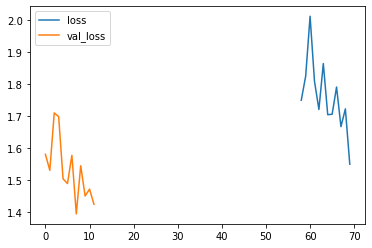

In [33]:
import matplotlib.pyplot as plt

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()